In [15]:
import os
import sys
sys.path.append(r'C:\Study\SpeechAcquisitionModel')
print(os.getcwd())
import numpy as np
from scipy.spatial.distance import euclidean, minkowski
import scipy
import torch
import yaml
from pprint import pprint

import dtw
import dtwalign
from fastdtw import fastdtw

from sklearn.manifold import TSNE
import pandas as pd

from src.speech_classification.audio_processing import AudioPreprocessorMFCCDeltaDelta, SpeechCommandsDataCollector
from src.siamese_net_sound_similarity.slstm_train import SiameseSpeechCommandsDataCollector, StochasticSiameseLSTMNet
from src.siamese_net_sound_similarity.train_v2_with_settle_structure import SiameseDeepLSTMNet
from src.siamese_net_sound_similarity.soft_dtw import SoftDTW



import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
sns.set()
sns.set(font_scale=1.4, rc={'text.usetex' : False})
sns.set_style("whitegrid")

%matplotlib inline

C:\Study\SpeechAcquisitionModel\src\dtw


In [16]:
DISTANCE='euclidean'
STEP_PATTERN = 'typeIc'
CLOSED_END_STEP_PATTERN = "typeIc"
# DISTANCE=lambda x, y : minkowski(x,y, 1)

## Load data

In [17]:
config_path = r'C:\Study\SpeechAcquisitionModel\reports\seamise_net_01_17_2020_01_36_PM\config.yaml'
with open(config_path, 'r') as data_file:
    config = yaml.safe_load(data_file)
pprint(config)

{'alpha': 0.0,
 'bidirectional': False,
 'dct_coefficient_count': 13,
 'dist': 'l1',
 'dropout': 0.3,
 'hidden_fc': None,
 'hidden_reccurent': [256, 256],
 'label_count': 32,
 'learning_rate': 0.0005,
 'loss_type': 'cos_hinge',
 'margin': 0.4,
 'mfcc_num': 39,
 'mini_batch_size': 64,
 'open_end': False,
 'save_dir': "r'C:\\Study\\SpeechAcquisitionModel\\models\\siamese_net_sound_similarity'",
 'train_steps': 50000,
 'triplet_anneal_b': 0,
 'triplet_anneal_k': 1000.0025,
 'wanted_words': ['bed',
                  'bird',
                  'cat',
                  'dog',
                  'down',
                  'eight',
                  'five',
                  'four',
                  'go',
                  'happy',
                  'house',
                  'left',
                  'marvin',
                  'nine',
                  'no',
                  'off',
                  'on',
                  'one',
                  'right',
                  'seven',
         

In [18]:
wanted_words = config['wanted_words']

wanted_words_combined = wanted_words

model_settings = config
query_length = 100

In [19]:
preproc = AudioPreprocessorMFCCDeltaDelta(numcep=model_settings['dct_coefficient_count'], winlen=model_settings['winlen'],
                                     winstep=model_settings['winstep'])

data_iter = SiameseSpeechCommandsDataCollector(preproc,
                                        data_dir=r'C:\Study\Speech_command_classification\speech_dataset',
                                        wanted_words=wanted_words_combined,
                                        testing_percentage=10,
                                        validation_percentage=10
                                        )

index_to_word = {v:k for k,v in data_iter.word_to_index.items()}

In [20]:
n_mini_batch_size = 1
data = data_iter.get_data(n_mini_batch_size, 0, 'training')
labels = data['y']

duplicates = data_iter.get_duplicates(labels, 0, 'training')
assert np.any(labels == duplicates['y'])

non_duplicates = data_iter.get_nonduplicates(labels, 0, 'training')
assert np.any(labels != non_duplicates['y'])

Text(0.5,1,'negative DTW = 68.9077')

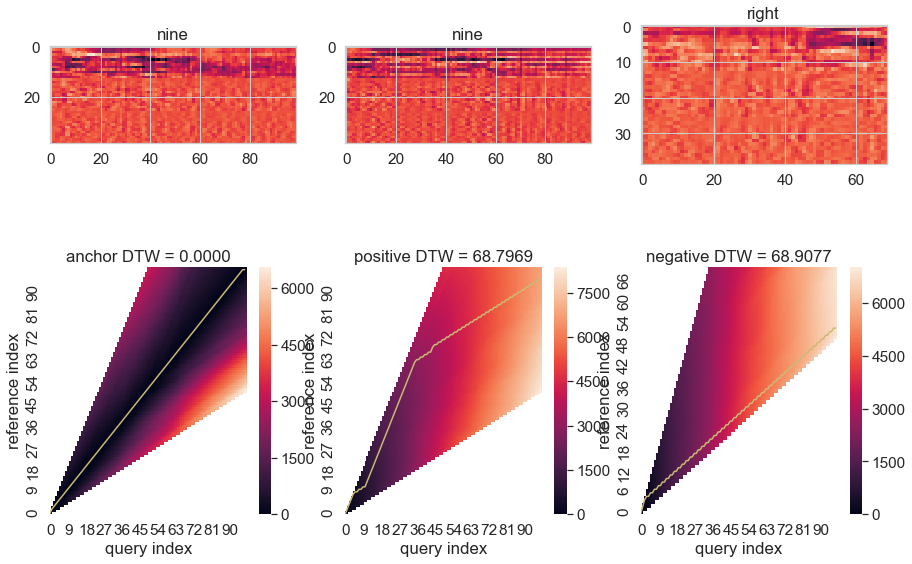

In [21]:

i = np.random.randint(data['y'].shape[0])
sample_idx = i

fig, axes = plt.subplots(2, 3, figsize=(15,10))

# plt.figure()
im = axes[0][0].imshow(data['x'][i].T)
# fig.colorbar(im)
label = index_to_word[data['y'][0]]
axes[0][0].title.set_text(f'{label}')

axes[0][1].imshow(duplicates['x'][i].T)
# plt.colorbar()
label = index_to_word[data['y'][0]]
axes[0][1].title.set_text(f'{label}')


axes[0][2].imshow(non_duplicates['x'][i].T)
# plt.colorbar()
label = index_to_word[non_duplicates['y'][0]]
axes[0][2].title.set_text(f'{label}')

######################################## DTW

x = data['x'][i]

# self dtw (extpected to be 0)

y = data['x'][i]
res = dtwalign.dtw(x, y, dist=DISTANCE, step_pattern=STEP_PATTERN, open_end=True)
res.plot_path(ax=axes[1][0])
axes[1][0].set_title(f"anchor DTW = {res.normalized_distance:.4f}")


# positive dtw

y = duplicates['x'][sample_idx]
res = dtwalign.dtw(x, y, dist=DISTANCE, step_pattern=STEP_PATTERN, open_end=True)
res.plot_path(ax=axes[1][1])
axes[1][1].set_title(f"positive DTW = {res.normalized_distance:.4f}")


# negative dtw

y = non_duplicates['x'][sample_idx]
res = dtwalign.dtw(x, y, dist=DISTANCE, step_pattern=STEP_PATTERN, open_end=True)
res.plot_path(ax=axes[1][2])
axes[1][2].set_title(f"negative DTW = {res.normalized_distance:.4f}")

# Gather Data for analysis

In [22]:
n_mini_batch_size = 1000

# # gather data
# data = data_iter.get_data(n_mini_batch_size, 0, 'validation')
# labels = data['y']

# data1 = data_iter.get_data(n_mini_batch_size, 0, 'validation')
# labels1 = data1['y']
# idx = np.random.randint(0, len(labels1), len(labels1))
# data1_x = data1['x'][idx]
# data1['x'] = data1_x
# labels1 =  np.array(data1['y'])[idx]
# data1['y'] = labels1




data = data_iter.get_data(n_mini_batch_size, 0, 'training')
labels = data['y']

duplicates = data_iter.get_duplicates(labels, 0, 'training')
assert np.any(labels == duplicates['y'])

non_duplicates = data_iter.get_nonduplicates(labels, 0, 'training')
assert np.any(labels != non_duplicates['y'])


In [29]:
nn_cos_hinge = r'C:\Study\SpeechAcquisitionModel\reports\seamise_net_01_19_2020_01_42_PM\net_41092_0.91796875.net'

nn_fnames = [nn_cos_hinge]
nn_names = ['COS_HINGE']

############################################################################
# MODEL : COS_HINGE
# DISTANCE: sdtw
############################################################################
tensor(-1.0000, grad_fn=<MinBackward1>)
tensor(1.0000, grad_fn=<MaxBackward1>)


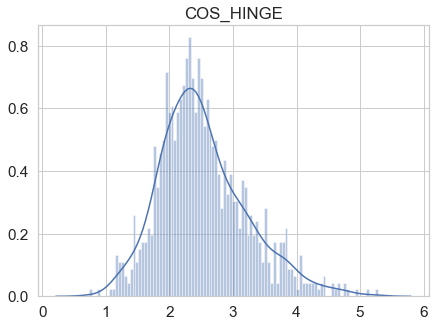

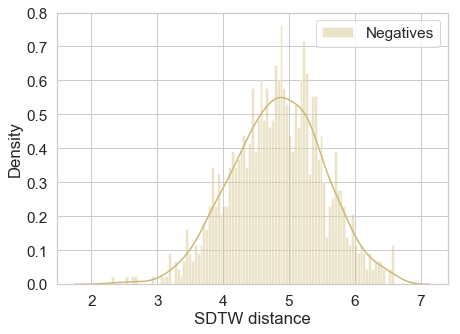

DKL is: 4.8862


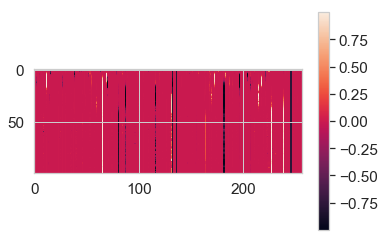

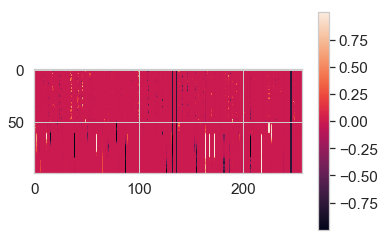

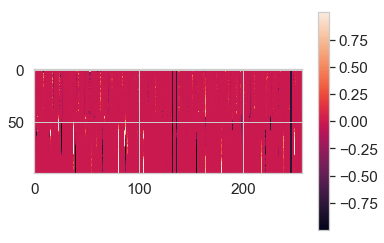

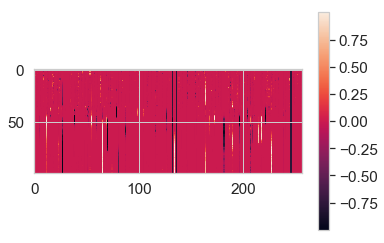

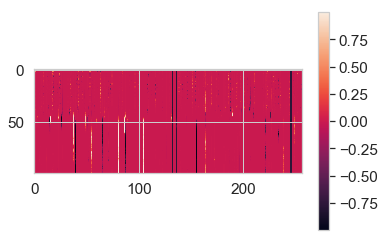

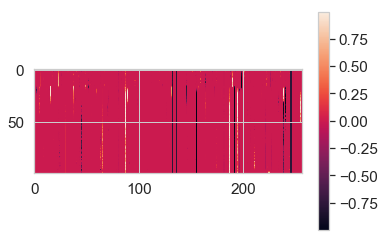

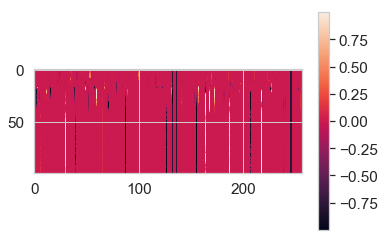

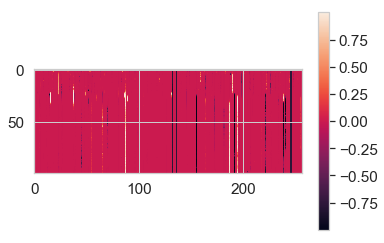

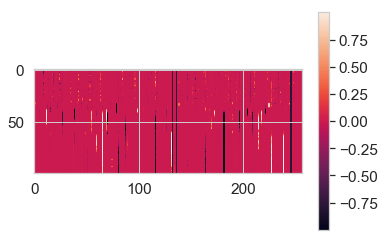

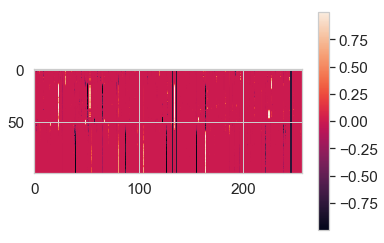

In [30]:
soft_dtw_loss_close_end = SoftDTW(open_end=False, dist='l1')
dists = {
    'sdtw': soft_dtw_loss_close_end,
    'l2': lambda x, y: torch.sum((x - y)**2, dim=-1)[-1],
    'cos_hinge': lambda x, y: 1 - torch.nn.CosineSimilarity(dim=0)(x[-1, :], y[-1, :]),
    'ce': soft_dtw_loss_close_end
}

for j in range(len(nn_fnames)):
    nn_fname = nn_fnames[j]
    config_path = os.path.join(os.path.dirname(nn_fname), 'config.yaml')
    with open(config_path, 'r') as data_file:
        config = yaml.safe_load(data_file)
   
    loss_type = config['loss_type']
    
    dist_func = dists[loss_type]

    nn = torch.load(nn_fname).cpu()
    nn.eval()

    print(f"############################################################################\n\
# MODEL : {nn_names[j]}\n\
# DISTANCE: {loss_type}\n\
############################################################################")
    
    PREFIX_LENS = [query_length]

    for PREFIX_LEN in PREFIX_LENS:
#         print(f"############################################################################\n\
# # PREFIX LENGTH : {PREFIX_LEN}\n\
# ############################################################################")
        nn_input = torch.from_numpy(data['x'][:, :PREFIX_LEN, :]).float()


        z, *_ = nn.single_forward(nn_input)
        z = z.cpu()
#         z_detach = z.detach().cpu().numpy()

        duplicates_z, *_ = nn.single_forward(torch.from_numpy(duplicates['x']).float())
        duplicates_z = duplicates_z
        print(duplicates_z.min())
        print(duplicates_z.max())


        non_duplicates_z, *_ = nn.single_forward(torch.from_numpy(non_duplicates['x']).float())
        non_duplicates_z = non_duplicates_z.cpu()

        plt.show()

        ###########################################################################
        # DTW
        ###########################################################################

       

        ##########################################################################
        # OPEN END = False
        ##########################################################################

        # initialize dist_lists

        duplicates_dtw_z = []
        non_duplicates_dtw_z = []

        duplicates_bmis = []
        non_duplicates_bmis = []

        for i in range(n_mini_batch_size):
            print(i, end='\r')
            x = z[i].squeeze()

            y_duplicate = duplicates_z[i].squeeze()
            d = dist_func(x, y_duplicate)
            duplicates_dtw_z.append(d.detach().cpu().numpy().squeeze())

            y_non_duplicate = non_duplicates_z[i].squeeze()
            d = dist_func(x, y_non_duplicate)
            non_duplicates_dtw_z.append(d.detach().cpu().numpy().squeeze())
        
#         print(np.array(duplicates_dtw_z))
        
        
        

        bins = np.linspace(np.min(duplicates_dtw_z),
                          np.max(duplicates_dtw_z),
                           100)
        fig, axes = plt.subplots(1, 1, figsize=(7,5))

        sns.distplot(duplicates_dtw_z, bins=bins, ax=axes, label="Positives")
        axes.title.set_text(f'{nn_names[j]}')

        bins = np.linspace(np.min(non_duplicates_dtw_z),
                          np.max(non_duplicates_dtw_z),
                           100)
        fig, axes = plt.subplots(1, 1, figsize=(7,5))
        
        sns.distplot(non_duplicates_dtw_z, bins=bins, color='y', ax=axes, label='Negatives')
        axes.legend()
        plt.xlabel(f'{loss_type.upper()} distance')
        plt.ylabel('Density')
        # axes[1].title.set_text('non-duplicates DTW')
        plt.show()

        hist_dup, _ = np.histogram(duplicates_dtw_z, bins=bins)
        hist_dup = hist_dup / np.sum(hist_dup)

        hist_non_dup, _ = np.histogram(non_duplicates_dtw_z, bins=bins)
        hist_non_dup = hist_non_dup / np.sum(hist_non_dup)

        dkl = scipy.special.kl_div(hist_dup+1e-5, hist_non_dup+1e-5).sum()
        print(f"DKL is: {dkl:.4f}")
        
        z = z.detach().numpy()

        for i in range(10):
            idx = np.random.randint(0, 1000)
            plt.figure()
            plt.imshow(z[idx])
            plt.colorbar()
            plt.show()
        del z, duplicates_z, non_duplicates_z, _
        
        
